SAN
====

**Side Adapter Network for Open-Vocabulary Semantic Segmentation**

 * Paper: https://arxiv.org/pdf/2302.12242

![SAN Overview](../assets/san_overview.jpg)

![SAN Architecture](../assets/san_arch.jpg)

![SAN using CLIP-attn to predict mask](../assets/san_attn-mask.jpg)

## Installation

```bash
sudo apt update
sudo apt install -y build-essential git pkg-config \
  libjpeg-dev libpng-dev libglib2.0-0 libsm6 libxext6 libxrender-dev

conda create -n san python=3.9 -y
condaq activate san

pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 \
  torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

python -c "import torch; print('CUDA available:', torch.cuda.is_available())"


git clone https://github.com/MendelXu/SAN.git SAN_repo
cd SAN_repo

pip install -r requirements.txt

# Install cuda-toolkit matching with pytorch's cuda version (11.3)
# nvcc 11.3 (matches PyTorch +cu113)
conda install -y -c nvidia/label/cuda-11.3.1 cuda-nvcc

# alternatively install full cuda 11.3
#conda install -y -c nvidia/label/cuda-11.3.1 cuda
nvcc -V  # should now report CUDA release 11.3

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# next install detectron2 (but I got the following error)
# error: #error – unsupported GNU version! gcc versions later than 8 are not supported!
# so, installing gcc-8
sudo apt update
sudo apt install -y gcc-8 g++-8

# Set CUDA_HOME to the location of the conda-installed toolkit
export CUDA_HOME=$(dirname $(dirname $(which nvcc)))
export PATH="$CUDA_HOME/bin:$PATH"
export LD_LIBRARY_PATH="$CUDA_HOME/lib64:$LD_LIBRARY_PATH"
# Build from source with the correct compiler
CC=gcc-8 CXX=g++-8 python -m pip install \
    'git+https://github.com/facebookresearch/detectron2.git@v0.6'

```

## Downgrade Numpy to avoid this error: `Numpy is not available`

```bash
pip install numpy==1.26.4

python -c "import numpy; print('NumPy version:', numpy.__version__)"
```

In [3]:
import os
import sys
import matplotlib.pyplot as plt

sys.path.append("SAN_repo")
from predict import Predictor, model_cfg


# Choose the ViT-B/16 model; the config and weight names come from predict.py.
model_key = "san_vit_b_16"
config_file = model_cfg[model_key]["config_file"]
model_path = model_cfg[model_key]["model_path"]
config_file = "SAN_repo/" + config_file

# Build the predictor.  This will download the weights from HuggingFace on first use.
predictor = Predictor(config_file=config_file, model_path=model_path)


/home/pyml/git_vmirly/GenAI-Hub/SAN/SAN_repo/san/model/side_adapter/timm_wrapper.py:24: UserWarning: Unused kwargs are provided:{'dynamic_img_pad': False}.
  warnings.warn(f"Unused kwargs are provided:{kwargs}.")


Loading model from:  /home/pyml/.cache/huggingface/hub/models--Mendel192--san/snapshots/0d24a51312b517e86044f845185d09002d032443/san_vit_b_16.pth
Loaded model from:  /home/pyml/.cache/huggingface/hub/models--Mendel192--san/snapshots/0d24a51312b517e86044f845185d09002d032443/san_vit_b_16.pth


In [4]:
    # Define the image path relative to this script.  Adjust as needed.
    image_path = "../samples/plants.jpg"

    # Run prediction.  An empty vocabulary list lets the model use its default categories.
    result = predictor.predict(image_path)

    # Extract and display results.
    sem_seg = result["sem_seg"]
    vocabulary = result["vocabulary"]

    print(f"Loaded image: {image_path}")
    print(f"Segmentation map shape: {sem_seg.shape}")
    print(f"Number of classes: {len(vocabulary)}")
    print("Classes:", vocabulary)


vocabulary: []
Loaded image: ../samples/plants.jpg
Segmentation map shape: (1137, 1068)
Number of classes: 171
Classes: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'banner', 'blanket

/home/pyml/anaconda3/envs/san/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


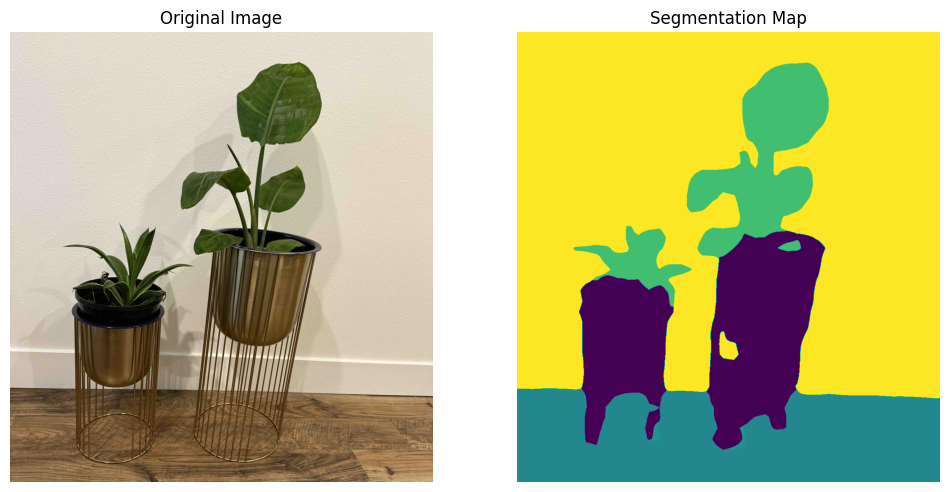

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
# Display the original image
original_image = plt.imread(image_path)
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(sem_seg)
axes[1].set_title("Segmentation Map")
axes[1].axis("off")

plt.show()